<a href="https://colab.research.google.com/github/Axazuki/cGAN-with-FMNIST/blob/main/cGAN_%D0%BD%D0%B0_%D0%B1%D0%B0%D0%B7%D0%B5_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключение библиотек

In [ ]:
from __future__ import print_function, division
from tensorflow.keras.datasets import mnist, cifar10, fashion_mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, concatenate, Embedding, multiply, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from google.colab import files
from IPython.display import clear_output
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt
import sys, random
import numpy as np
import os

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


# Объявление переменных и загрузка данных

In [ ]:
img_rows = 28 # Высота изображения в пикселях
img_cols = 28 # Ширина изображения в пикселях
channels = 1 # Количество каналов (глубина изображения)
img_shape = (img_rows, img_cols, channels) # Размерность входных данных для набора Mnist
latent_dim = 100 # Размерность скрытого пространства
batch_size = 128 # Размер batch_size

optimizer = Adam(0.0002, 0.5) # Оптимайзер

In [ ]:
# Загружаем Mnist
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()
x_train_mnist = np.concatenate([x_train_mnist, x_test_mnist])
y_train_mnist = np.concatenate([y_train_mnist, y_test_mnist])

# Масштабируем размер в диапазон от -1 до 1
x_train_mnist = x_train_mnist/ 127.5 - 1.0
x_train_mnist = x_train_mnist.reshape(x_train_mnist.shape[0], 28, 28, 1)
print(x_train_mnist.shape)
print(y_train_mnist.shape)


11501568/11490434 [==============================] - 0s 0us/step
(70000, 28, 28, 1)
(70000,)


In [ ]:
# Загружаем Fashion Mnist
(x_train_F_mnist, y_train_F_mnist), (x_test_F_mnist, y_test_F_mnist) = fashion_mnist.load_data()
x_train_F_mnist=np.concatenate([x_train_F_mnist,x_test_F_mnist])
y_train_F_mnist=np.concatenate([y_train_F_mnist,y_test_F_mnist])

# xTrainMnistF = xTrainMnistF.astype('float32')/255 # представляем в виде значений от 0 до 1
x_train_F_mnist = x_train_F_mnist / 127.5 - 1.0
x_train_F_mnist = x_train_F_mnist.reshape(x_train_F_mnist.shape[0], 28, 28, 1) # меняем форму, приводим к нужным нам размерам
print(x_train_F_mnist.shape)
print(y_train_F_mnist.shape)


4431872/4422102 [==============================] - 0s 0us/step
(70000, 28, 28, 1)
(70000,)


In [ ]:
num_classes = 10
print('Fashion MNIST')
for i in range (num_classes):
  temp = np.array(np.where(y_train_F_mnist==i))  
  print(temp.shape)
print()
print('MNIST')
for i in range (num_classes):
  temp = np.array(np.where(y_train_mnist==i))  
  print(temp.shape)

Fashion MNIST
(1, 7000)
(1, 7000)
(1, 7000)
(1, 7000)
(1, 7000)
(1, 7000)
(1, 7000)
(1, 7000)
(1, 7000)
(1, 7000)

MNIST
(1, 6903)
(1, 7877)
(1, 6990)
(1, 7141)
(1, 6824)
(1, 6313)
(1, 6876)
(1, 7293)
(1, 6825)
(1, 6958)


## Сортировка изображений из MNIST в соответствии с FASHION-MNIST

In [ ]:
# Функция, которая синхронизирует данные Mnist и Fashion Mnist
def create_sorted_xtrain(trainLen):
  train_mnist = []
  train_F_mnist = []
  
  for i in range(10):
    curr_train_mnist = x_train_mnist[y_train_mnist==i,:]
    curr_trainF_mnist = x_train_F_mnist[y_train_F_mnist.flatten()==i,:]
    curr_train_mnist = curr_train_mnist[:trainLen]
    curr_trainF_mnist = curr_trainF_mnist[:trainLen]
    train_mnist.extend(list(curr_train_mnist))
    train_F_mnist.extend(list(curr_trainF_mnist))

  train_mnist = np.array(train_mnist)
  train_F_mnist = np.array(train_F_mnist)

  return train_mnist, train_F_mnist

In [ ]:
train_mnist, train_F_mnist = create_sorted_xtrain(6300)

In [ ]:
train_F_mnist.shape

(63000, 28, 28, 1)

In [ ]:
def plot_images(start_index, xTrain, pred):
  n = 5  # Количество картинок, которые хотим показать
  plt.figure(figsize=(10, 4))
  for i in range(n):
      index = i + start_index
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(xTrain[index].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(pred[index].reshape(28,28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

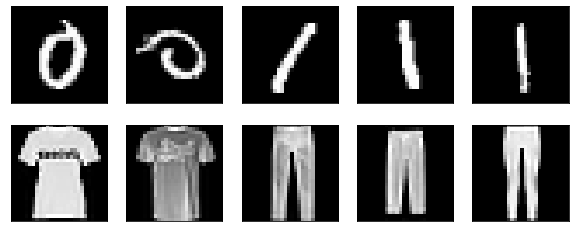

In [ ]:
# Получаем 5000 картинок MNIST, для Fashion Mnist будет только 10 картинок - по 1 для каждого класса
plot_images(6298, train_mnist, train_F_mnist)

# Генератор и дискриминатор (сверточная архитектура)

In [ ]:
noise_chanells=128
def create_conditional_generator():
  generator = Sequential()
  generator.add (Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  generator.add (LeakyReLU(alpha=0.2))
  generator.add (Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  generator.add (LeakyReLU(alpha=0.2))
  generator.add (Conv2D (1, (7,7), activation='tanh', padding='same'))

  noise = Input(shape=(latent_dim,))
  noise_modify = Dense (noise_chanells * 7 * 7) (noise)
  noise_modify = LeakyReLU (alpha=0.2) (noise_modify)
  noise_modify = Reshape ((7,7,noise_chanells)) (noise_modify)
  
  label = Input(shape=(28,28,1))
  label_modify = Flatten() (label)
  label_modify = Dense (7*7) (label_modify)
  label_modify = Reshape ((7,7,1)) (label_modify)

  model_input = concatenate([noise_modify, label_modify])
  img = generator(model_input)

  generator = Model([noise, label], img)
  
  return generator

In [ ]:
def create_conditional_discriminator():
  
  discriminator = Sequential()
  discriminator.add(Conv2D(32,(3,3),strides=(2,2), padding='same'))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Conv2D(32,(3,3),strides=(2,2), padding='same'))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Flatten())
  discriminator.add(Dense(32))
  discriminator.add(Dropout(0.4))
  discriminator.add(Dense(1,activation='sigmoid'))  
  
  img = Input(shape=img_shape)

  label = Input(shape=(28,28,1))

  model_input = concatenate([img,label])

  #model_input = multiply([flat_img, label_embedding])
  validity = discriminator(model_input)

  discriminator = Model([img, label], validity)

  discriminator.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

  discriminator.trainable = False

  return discriminator

# Обучение

In [ ]:
yTrain=[]
for i in range(10):
  yTrain.extend([i for n in range(6300)])
yTrain=np.array(yTrain)

In [ ]:
def sample_images_conditional(epoch, gen):
  r, c = 2, 5
  noise = np.random.normal(0, 1, (r * c, latent_dim))
  sampled_labels=[]
  # Генерируем массив из 10 случайных меток (от 0 до 9)  
  for i in range(num_classes):    
    # Берём случайную метку из всех меток i-го класса
    sampled_labels.append(train_mnist[yTrain==i][np.random.randint(0,train_mnist[yTrain==i].shape[0])])
  sampled_labels = np.array(sampled_labels)
  gen_imgs = gen.predict([noise, sampled_labels])

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
      for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt].reshape((28,28)), cmap='gray')
          axs[i,j].axis('off')
          cnt += 1
  plt.show()

  plt.close()

In [ ]:
def train_conditional(generator, discriminator, epochs=30000, batch_size=128, sample_interval = 200):
  valid = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))
  
  noise = Input(shape=(latent_dim,))
  label = Input(shape=img_shape)
  img = generator([noise, label])
  
  val = discriminator([img, label])
  
  combined = Model([noise, label], val)
  combined.compile(loss=['binary_crossentropy'],
      optimizer=optimizer)

  
  d_loss_list = []
  g_loss_list = []
  d_acc_list = []
  
  for epoch in range(epochs):
    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random batch of images
    
    idx1 = np.random.randint(0, train_F_mnist.shape[0], batch_size)    
    imgs = train_F_mnist[idx1]
    labels = train_mnist[idx1]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Generate a batch of new images
    gen_imgs = generator.predict([noise, labels])
    
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    idx2 = np.random.randint(0, train_mnist.shape[0], batch_size)
    sampled_labels = train_mnist[idx2]
    
    # Train the generator (to have the discriminator label samples as valid)
    g_loss = combined.train_on_batch([noise, sampled_labels], valid)

    # Plot the progress
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    d_loss_list.append(d_loss[0])
    g_loss_list.append(g_loss)
    d_acc_list.append(100*d_loss[1])

    # If at save interval => save generated image samples
    if ((epoch % sample_interval == 0) | (epoch == epochs-1)):
        sample_images_conditional(epoch, generator)
        
  plt.plot(d_loss_list, label="Ошибка дискриминатора")
  plt.plot(g_loss_list, label="Ошибка генератора")
  plt.legend()
  plt.show()
  plt.plot(d_acc_list, label="Точность распознавания дискриминатора")
  plt.legend()
  plt.show()
    

In [ ]:
conditional_generator = create_conditional_generator()
conditional_discriminator = create_conditional_discriminator()

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0 [D loss: 0.742105, acc.: 37.89%] [G loss: 0.742628]


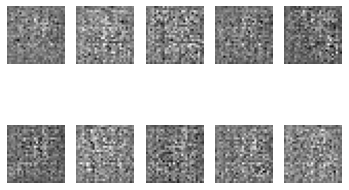

1 [D loss: 0.693061, acc.: 51.95%] [G loss: 0.720610]
2 [D loss: 0.673268, acc.: 56.64%] [G loss: 0.706833]
3 [D loss: 0.662130, acc.: 58.59%] [G loss: 0.712849]
4 [D loss: 0.632388, acc.: 64.06%] [G loss: 0.711179]
5 [D loss: 0.630911, acc.: 59.38%] [G loss: 0.691635]
6 [D loss: 0.628469, acc.: 57.03%] [G loss: 0.659084]
7 [D loss: 0.652947, acc.: 53.91%] [G loss: 0.621497]
8 [D loss: 0.685130, acc.: 50.39%] [G loss: 0.589929]
9 [D loss: 0.699543, acc.: 50.39%] [G loss: 0.629145]
10 [D loss: 0.662005, acc.: 54.30%] [G loss: 0.717563]
11 [D loss: 0.633734, acc.: 65.23%] [G loss: 0.846249]
12 [D loss: 0.623514, acc.: 64.45%] [G loss: 0.853190]
13 [D loss: 0.700360, acc.: 47.66%] [G loss: 0.687615]
14 [D loss: 0.760921, acc.: 35.16%] [G loss: 0.596858]
15 [D loss: 0.731381, acc.: 44.14%] [G loss: 0.600921]
16 [D loss: 0.770721, acc.: 35.94%] [G loss: 0.598738]
17 [D loss: 0.785844, acc.: 42.97%] [G loss: 0.544656]
18 [D loss: 0.799702, acc.: 43.75%] [G loss: 0.531729]
19 [D loss: 0.77304

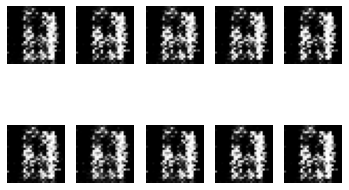

201 [D loss: 0.809251, acc.: 25.78%] [G loss: 0.677335]
202 [D loss: 0.793002, acc.: 26.95%] [G loss: 0.714146]
203 [D loss: 0.793841, acc.: 24.61%] [G loss: 0.738754]
204 [D loss: 0.769693, acc.: 34.38%] [G loss: 0.785855]
205 [D loss: 0.755820, acc.: 38.28%] [G loss: 0.838193]
206 [D loss: 0.741440, acc.: 45.70%] [G loss: 0.859140]
207 [D loss: 0.724495, acc.: 50.39%] [G loss: 0.868639]
208 [D loss: 0.719429, acc.: 50.78%] [G loss: 0.877856]
209 [D loss: 0.705662, acc.: 58.59%] [G loss: 0.897860]
210 [D loss: 0.688817, acc.: 59.38%] [G loss: 0.879400]
211 [D loss: 0.676518, acc.: 65.23%] [G loss: 0.884131]
212 [D loss: 0.680676, acc.: 61.33%] [G loss: 0.859998]
213 [D loss: 0.694466, acc.: 58.20%] [G loss: 0.840552]
214 [D loss: 0.687388, acc.: 60.16%] [G loss: 0.856471]
215 [D loss: 0.680751, acc.: 56.25%] [G loss: 0.834068]
216 [D loss: 0.686046, acc.: 56.64%] [G loss: 0.831148]
217 [D loss: 0.683733, acc.: 54.69%] [G loss: 0.803279]
218 [D loss: 0.695414, acc.: 54.69%] [G loss: 0.

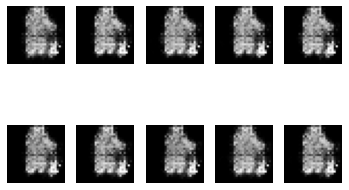

401 [D loss: 0.697240, acc.: 48.44%] [G loss: 0.713732]
402 [D loss: 0.716388, acc.: 42.19%] [G loss: 0.693861]
403 [D loss: 0.740953, acc.: 31.64%] [G loss: 0.653777]
404 [D loss: 0.767507, acc.: 31.64%] [G loss: 0.632548]
405 [D loss: 0.787176, acc.: 25.39%] [G loss: 0.618762]
406 [D loss: 0.775545, acc.: 24.61%] [G loss: 0.633160]
407 [D loss: 0.788915, acc.: 25.00%] [G loss: 0.649197]
408 [D loss: 0.776888, acc.: 26.56%] [G loss: 0.664062]
409 [D loss: 0.749195, acc.: 33.20%] [G loss: 0.666254]
410 [D loss: 0.758994, acc.: 27.34%] [G loss: 0.674161]
411 [D loss: 0.767856, acc.: 25.00%] [G loss: 0.671818]
412 [D loss: 0.777621, acc.: 23.44%] [G loss: 0.675960]
413 [D loss: 0.783751, acc.: 19.53%] [G loss: 0.646266]
414 [D loss: 0.793057, acc.: 16.80%] [G loss: 0.637830]
415 [D loss: 0.821774, acc.: 12.11%] [G loss: 0.624702]
416 [D loss: 0.820192, acc.: 10.94%] [G loss: 0.622666]
417 [D loss: 0.818942, acc.: 8.98%] [G loss: 0.624534]
418 [D loss: 0.806443, acc.: 11.72%] [G loss: 0.6

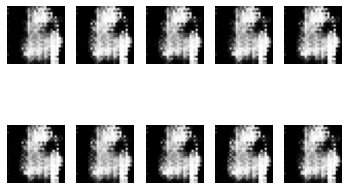

601 [D loss: 0.649727, acc.: 60.55%] [G loss: 0.812771]
602 [D loss: 0.713590, acc.: 39.84%] [G loss: 0.702637]
603 [D loss: 0.776579, acc.: 35.55%] [G loss: 0.601936]
604 [D loss: 0.882288, acc.: 28.52%] [G loss: 0.530205]
605 [D loss: 0.956626, acc.: 25.00%] [G loss: 0.498449]
606 [D loss: 0.917331, acc.: 20.70%] [G loss: 0.562772]
607 [D loss: 0.848530, acc.: 18.36%] [G loss: 0.692232]
608 [D loss: 0.783098, acc.: 27.73%] [G loss: 0.845368]
609 [D loss: 0.744143, acc.: 47.27%] [G loss: 0.948698]
610 [D loss: 0.703980, acc.: 54.30%] [G loss: 1.080754]
611 [D loss: 0.662161, acc.: 60.55%] [G loss: 1.125452]
612 [D loss: 0.644064, acc.: 62.89%] [G loss: 1.167453]
613 [D loss: 0.652966, acc.: 66.41%] [G loss: 1.093296]
614 [D loss: 0.689466, acc.: 64.45%] [G loss: 1.004603]
615 [D loss: 0.715834, acc.: 60.55%] [G loss: 0.869864]
616 [D loss: 0.737326, acc.: 46.09%] [G loss: 0.780437]
617 [D loss: 0.754706, acc.: 42.97%] [G loss: 0.702787]
618 [D loss: 0.788104, acc.: 26.95%] [G loss: 0.

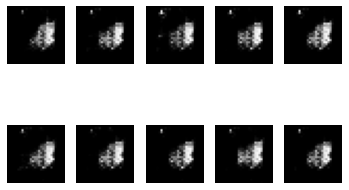

801 [D loss: 0.643515, acc.: 71.09%] [G loss: 0.899283]
802 [D loss: 0.632929, acc.: 69.92%] [G loss: 0.892361]
803 [D loss: 0.627153, acc.: 74.22%] [G loss: 0.898569]
804 [D loss: 0.622896, acc.: 77.34%] [G loss: 0.904413]
805 [D loss: 0.616118, acc.: 75.78%] [G loss: 0.914301]
806 [D loss: 0.596740, acc.: 81.64%] [G loss: 0.916745]
807 [D loss: 0.605063, acc.: 78.91%] [G loss: 0.903752]
808 [D loss: 0.612547, acc.: 76.56%] [G loss: 0.895131]
809 [D loss: 0.619443, acc.: 74.61%] [G loss: 0.884636]
810 [D loss: 0.642008, acc.: 71.88%] [G loss: 0.852051]
811 [D loss: 0.643824, acc.: 71.48%] [G loss: 0.831673]
812 [D loss: 0.665780, acc.: 61.72%] [G loss: 0.778816]
813 [D loss: 0.681495, acc.: 51.56%] [G loss: 0.751760]
814 [D loss: 0.680297, acc.: 47.27%] [G loss: 0.711893]
815 [D loss: 0.706863, acc.: 44.53%] [G loss: 0.723011]
816 [D loss: 0.701974, acc.: 46.48%] [G loss: 0.718559]
817 [D loss: 0.714393, acc.: 44.92%] [G loss: 0.735403]
818 [D loss: 0.725470, acc.: 38.67%] [G loss: 0.

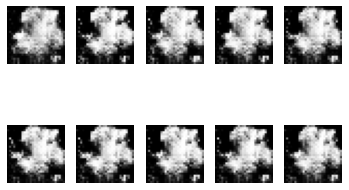

1001 [D loss: 0.641209, acc.: 45.70%] [G loss: 0.687766]
1002 [D loss: 0.766743, acc.: 37.11%] [G loss: 0.557872]
1003 [D loss: 0.827510, acc.: 40.62%] [G loss: 0.487171]
1004 [D loss: 0.853919, acc.: 38.28%] [G loss: 0.486395]
1005 [D loss: 0.885139, acc.: 32.81%] [G loss: 0.496019]
1006 [D loss: 0.878264, acc.: 29.69%] [G loss: 0.531204]
1007 [D loss: 0.928766, acc.: 17.58%] [G loss: 0.535031]
1008 [D loss: 0.927002, acc.: 14.06%] [G loss: 0.561007]
1009 [D loss: 0.860372, acc.: 8.59%] [G loss: 0.624940]
1010 [D loss: 0.826794, acc.: 12.89%] [G loss: 0.700742]
1011 [D loss: 0.789561, acc.: 25.78%] [G loss: 0.766962]
1012 [D loss: 0.755970, acc.: 40.23%] [G loss: 0.811474]
1013 [D loss: 0.747264, acc.: 44.92%] [G loss: 0.840072]
1014 [D loss: 0.718114, acc.: 53.12%] [G loss: 0.859423]
1015 [D loss: 0.696905, acc.: 57.42%] [G loss: 0.893602]
1016 [D loss: 0.685181, acc.: 60.16%] [G loss: 0.923717]
1017 [D loss: 0.661734, acc.: 62.50%] [G loss: 0.925759]
1018 [D loss: 0.660436, acc.: 61

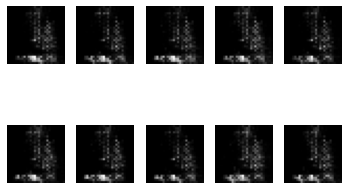

1201 [D loss: 0.708248, acc.: 50.00%] [G loss: 0.776892]
1202 [D loss: 0.681980, acc.: 57.81%] [G loss: 0.833280]
1203 [D loss: 0.680911, acc.: 56.64%] [G loss: 0.854195]
1204 [D loss: 0.669963, acc.: 58.59%] [G loss: 0.865259]
1205 [D loss: 0.666980, acc.: 60.16%] [G loss: 0.822470]
1206 [D loss: 0.665344, acc.: 62.89%] [G loss: 0.813578]
1207 [D loss: 0.690225, acc.: 61.72%] [G loss: 0.772921]
1208 [D loss: 0.707307, acc.: 49.61%] [G loss: 0.727122]
1209 [D loss: 0.703923, acc.: 50.39%] [G loss: 0.680500]
1210 [D loss: 0.725779, acc.: 41.41%] [G loss: 0.684887]
1211 [D loss: 0.747698, acc.: 37.11%] [G loss: 0.655395]
1212 [D loss: 0.766951, acc.: 34.38%] [G loss: 0.646500]
1213 [D loss: 0.779802, acc.: 27.34%] [G loss: 0.648831]
1214 [D loss: 0.766519, acc.: 36.72%] [G loss: 0.658484]
1215 [D loss: 0.772587, acc.: 30.47%] [G loss: 0.670085]
1216 [D loss: 0.761929, acc.: 32.81%] [G loss: 0.662402]
1217 [D loss: 0.754445, acc.: 36.33%] [G loss: 0.662234]
1218 [D loss: 0.767202, acc.: 3

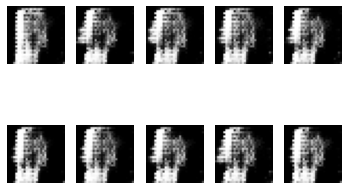

1401 [D loss: 0.600638, acc.: 79.30%] [G loss: 0.931469]
1402 [D loss: 0.616795, acc.: 74.61%] [G loss: 0.896470]
1403 [D loss: 0.625365, acc.: 76.56%] [G loss: 0.871062]
1404 [D loss: 0.623373, acc.: 74.61%] [G loss: 0.877037]
1405 [D loss: 0.617432, acc.: 72.66%] [G loss: 0.881245]
1406 [D loss: 0.606147, acc.: 76.17%] [G loss: 0.893309]
1407 [D loss: 0.603444, acc.: 80.86%] [G loss: 0.876029]
1408 [D loss: 0.593222, acc.: 78.52%] [G loss: 0.894591]
1409 [D loss: 0.604522, acc.: 79.69%] [G loss: 0.892949]
1410 [D loss: 0.611778, acc.: 76.17%] [G loss: 0.851931]
1411 [D loss: 0.614695, acc.: 75.00%] [G loss: 0.853856]
1412 [D loss: 0.636212, acc.: 69.14%] [G loss: 0.809309]
1413 [D loss: 0.635321, acc.: 67.97%] [G loss: 0.824335]
1414 [D loss: 0.619461, acc.: 76.17%] [G loss: 0.870816]
1415 [D loss: 0.634595, acc.: 75.39%] [G loss: 0.857622]
1416 [D loss: 0.606443, acc.: 78.91%] [G loss: 0.891423]
1417 [D loss: 0.606350, acc.: 79.30%] [G loss: 0.921295]
1418 [D loss: 0.608489, acc.: 7

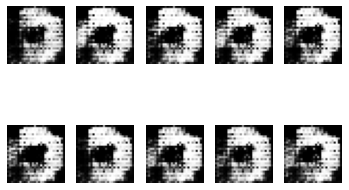

1601 [D loss: 0.593841, acc.: 76.56%] [G loss: 1.046251]
1602 [D loss: 0.623319, acc.: 67.19%] [G loss: 0.872512]
1603 [D loss: 0.675775, acc.: 55.47%] [G loss: 0.797369]
1604 [D loss: 0.782486, acc.: 37.11%] [G loss: 0.699120]
1605 [D loss: 0.762618, acc.: 36.33%] [G loss: 0.660275]
1606 [D loss: 0.774832, acc.: 37.50%] [G loss: 0.672336]
1607 [D loss: 0.759916, acc.: 40.23%] [G loss: 0.702377]
1608 [D loss: 0.765705, acc.: 40.62%] [G loss: 0.766616]
1609 [D loss: 0.706532, acc.: 52.73%] [G loss: 0.831576]
1610 [D loss: 0.673703, acc.: 62.11%] [G loss: 0.916832]
1611 [D loss: 0.642159, acc.: 69.14%] [G loss: 0.963522]
1612 [D loss: 0.609783, acc.: 74.22%] [G loss: 0.990698]
1613 [D loss: 0.585209, acc.: 73.83%] [G loss: 1.070271]
1614 [D loss: 0.552251, acc.: 82.03%] [G loss: 1.134280]
1615 [D loss: 0.522691, acc.: 86.72%] [G loss: 1.170080]
1616 [D loss: 0.510964, acc.: 87.11%] [G loss: 1.254933]
1617 [D loss: 0.490102, acc.: 90.23%] [G loss: 1.252249]
1618 [D loss: 0.492507, acc.: 8

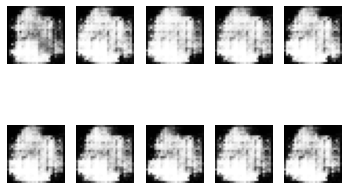

1801 [D loss: 0.595198, acc.: 78.12%] [G loss: 1.092023]
1802 [D loss: 0.569175, acc.: 81.25%] [G loss: 1.089598]
1803 [D loss: 0.587447, acc.: 80.86%] [G loss: 1.027397]
1804 [D loss: 0.599558, acc.: 79.69%] [G loss: 0.980882]
1805 [D loss: 0.627324, acc.: 78.52%] [G loss: 0.903727]
1806 [D loss: 0.636967, acc.: 69.92%] [G loss: 0.806336]
1807 [D loss: 0.669024, acc.: 54.30%] [G loss: 0.728478]
1808 [D loss: 0.749518, acc.: 39.84%] [G loss: 0.651150]
1809 [D loss: 0.764523, acc.: 35.94%] [G loss: 0.603018]
1810 [D loss: 0.790306, acc.: 35.55%] [G loss: 0.577109]
1811 [D loss: 0.834400, acc.: 30.86%] [G loss: 0.614558]
1812 [D loss: 0.805359, acc.: 25.78%] [G loss: 0.648907]
1813 [D loss: 0.787902, acc.: 28.91%] [G loss: 0.694938]
1814 [D loss: 0.763156, acc.: 36.33%] [G loss: 0.790336]
1815 [D loss: 0.726509, acc.: 45.70%] [G loss: 0.801834]
1816 [D loss: 0.694672, acc.: 57.03%] [G loss: 0.864961]
1817 [D loss: 0.694763, acc.: 59.77%] [G loss: 0.888936]
1818 [D loss: 0.686350, acc.: 6

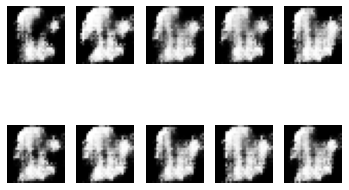

2001 [D loss: 0.722744, acc.: 46.48%] [G loss: 0.767626]
2002 [D loss: 0.669541, acc.: 60.16%] [G loss: 0.797646]
2003 [D loss: 0.662855, acc.: 61.72%] [G loss: 0.858166]
2004 [D loss: 0.646044, acc.: 64.84%] [G loss: 0.878262]
2005 [D loss: 0.653034, acc.: 67.19%] [G loss: 0.908975]
2006 [D loss: 0.599889, acc.: 75.00%] [G loss: 0.940322]
2007 [D loss: 0.595224, acc.: 74.61%] [G loss: 0.959258]
2008 [D loss: 0.572942, acc.: 78.52%] [G loss: 0.970637]
2009 [D loss: 0.565188, acc.: 78.12%] [G loss: 0.962024]
2010 [D loss: 0.590971, acc.: 73.83%] [G loss: 0.908298]
2011 [D loss: 0.555540, acc.: 78.91%] [G loss: 0.894016]
2012 [D loss: 0.615793, acc.: 68.36%] [G loss: 0.837132]
2013 [D loss: 0.602653, acc.: 67.97%] [G loss: 0.812745]
2014 [D loss: 0.623785, acc.: 59.77%] [G loss: 0.758158]
2015 [D loss: 0.649210, acc.: 51.95%] [G loss: 0.703104]
2016 [D loss: 0.732291, acc.: 39.06%] [G loss: 0.623657]
2017 [D loss: 0.800843, acc.: 31.25%] [G loss: 0.586419]
2018 [D loss: 0.760880, acc.: 3

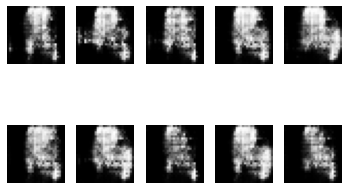

2201 [D loss: 0.635460, acc.: 70.31%] [G loss: 0.874537]
2202 [D loss: 0.609047, acc.: 75.00%] [G loss: 0.887262]
2203 [D loss: 0.595300, acc.: 77.34%] [G loss: 0.916322]
2204 [D loss: 0.618877, acc.: 73.44%] [G loss: 0.892047]
2205 [D loss: 0.595854, acc.: 77.34%] [G loss: 0.911095]
2206 [D loss: 0.585196, acc.: 80.08%] [G loss: 0.936487]
2207 [D loss: 0.584802, acc.: 78.52%] [G loss: 0.935314]
2208 [D loss: 0.575885, acc.: 76.95%] [G loss: 0.928146]
2209 [D loss: 0.560731, acc.: 80.86%] [G loss: 0.931755]
2210 [D loss: 0.602240, acc.: 71.09%] [G loss: 0.919258]
2211 [D loss: 0.609734, acc.: 70.70%] [G loss: 0.838116]
2212 [D loss: 0.635002, acc.: 65.62%] [G loss: 0.794196]
2213 [D loss: 0.668668, acc.: 57.03%] [G loss: 0.722086]
2214 [D loss: 0.722097, acc.: 45.70%] [G loss: 0.639766]
2215 [D loss: 0.737297, acc.: 42.97%] [G loss: 0.612138]
2216 [D loss: 0.770140, acc.: 37.11%] [G loss: 0.577080]
2217 [D loss: 0.791327, acc.: 33.98%] [G loss: 0.590782]
2218 [D loss: 0.748766, acc.: 4

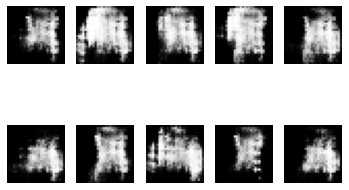

2401 [D loss: 0.654879, acc.: 65.62%] [G loss: 0.822224]
2402 [D loss: 0.653897, acc.: 64.45%] [G loss: 0.828387]
2403 [D loss: 0.659490, acc.: 62.89%] [G loss: 0.821350]
2404 [D loss: 0.651106, acc.: 67.97%] [G loss: 0.796321]
2405 [D loss: 0.662367, acc.: 62.50%] [G loss: 0.808594]
2406 [D loss: 0.664252, acc.: 59.38%] [G loss: 0.822931]
2407 [D loss: 0.660807, acc.: 62.50%] [G loss: 0.817852]
2408 [D loss: 0.655792, acc.: 64.06%] [G loss: 0.839328]
2409 [D loss: 0.676575, acc.: 58.20%] [G loss: 0.807570]
2410 [D loss: 0.644805, acc.: 64.45%] [G loss: 0.835971]
2411 [D loss: 0.682236, acc.: 57.03%] [G loss: 0.814391]
2412 [D loss: 0.660997, acc.: 63.28%] [G loss: 0.832422]
2413 [D loss: 0.669725, acc.: 59.38%] [G loss: 0.816465]
2414 [D loss: 0.673676, acc.: 57.42%] [G loss: 0.806119]
2415 [D loss: 0.651338, acc.: 63.67%] [G loss: 0.841482]
2416 [D loss: 0.673781, acc.: 55.86%] [G loss: 0.804187]
2417 [D loss: 0.682667, acc.: 54.30%] [G loss: 0.751830]
2418 [D loss: 0.674367, acc.: 5

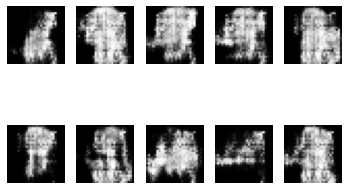

2601 [D loss: 0.710994, acc.: 48.83%] [G loss: 0.722127]
2602 [D loss: 0.695585, acc.: 51.17%] [G loss: 0.704254]
2603 [D loss: 0.705961, acc.: 45.31%] [G loss: 0.732541]
2604 [D loss: 0.701283, acc.: 51.95%] [G loss: 0.714550]
2605 [D loss: 0.700966, acc.: 48.83%] [G loss: 0.721349]
2606 [D loss: 0.704076, acc.: 48.05%] [G loss: 0.719126]
2607 [D loss: 0.697965, acc.: 50.00%] [G loss: 0.702645]
2608 [D loss: 0.698934, acc.: 50.00%] [G loss: 0.718613]
2609 [D loss: 0.708457, acc.: 46.09%] [G loss: 0.712481]
2610 [D loss: 0.698181, acc.: 50.00%] [G loss: 0.706619]
2611 [D loss: 0.705717, acc.: 46.09%] [G loss: 0.701075]
2612 [D loss: 0.708002, acc.: 48.44%] [G loss: 0.708569]
2613 [D loss: 0.702753, acc.: 46.88%] [G loss: 0.710423]
2614 [D loss: 0.703035, acc.: 50.00%] [G loss: 0.702473]
2615 [D loss: 0.696839, acc.: 52.73%] [G loss: 0.724616]
2616 [D loss: 0.709567, acc.: 46.48%] [G loss: 0.694466]
2617 [D loss: 0.710636, acc.: 46.09%] [G loss: 0.723470]
2618 [D loss: 0.693490, acc.: 5

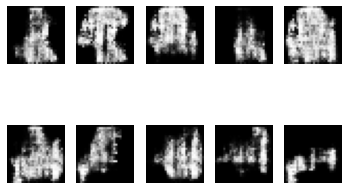

2801 [D loss: 0.694146, acc.: 53.12%] [G loss: 0.701212]
2802 [D loss: 0.703779, acc.: 48.44%] [G loss: 0.723115]
2803 [D loss: 0.704817, acc.: 46.09%] [G loss: 0.698984]
2804 [D loss: 0.698167, acc.: 53.91%] [G loss: 0.709506]
2805 [D loss: 0.706372, acc.: 45.70%] [G loss: 0.705005]
2806 [D loss: 0.707027, acc.: 50.00%] [G loss: 0.703858]
2807 [D loss: 0.693841, acc.: 52.34%] [G loss: 0.715482]
2808 [D loss: 0.698102, acc.: 47.27%] [G loss: 0.710426]
2809 [D loss: 0.692719, acc.: 52.73%] [G loss: 0.719355]
2810 [D loss: 0.690382, acc.: 52.34%] [G loss: 0.715996]
2811 [D loss: 0.693192, acc.: 49.61%] [G loss: 0.714615]
2812 [D loss: 0.687106, acc.: 55.47%] [G loss: 0.726469]
2813 [D loss: 0.689045, acc.: 54.69%] [G loss: 0.719836]
2814 [D loss: 0.700107, acc.: 50.78%] [G loss: 0.706810]
2815 [D loss: 0.685663, acc.: 51.95%] [G loss: 0.717834]
2816 [D loss: 0.699354, acc.: 52.34%] [G loss: 0.712543]
2817 [D loss: 0.684973, acc.: 56.64%] [G loss: 0.731707]
2818 [D loss: 0.698082, acc.: 5

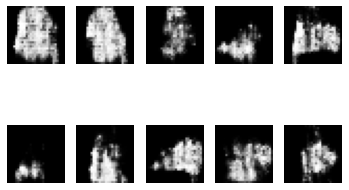

3001 [D loss: 0.699212, acc.: 46.88%] [G loss: 0.702137]
3002 [D loss: 0.706261, acc.: 48.44%] [G loss: 0.707265]
3003 [D loss: 0.699234, acc.: 52.73%] [G loss: 0.701760]
3004 [D loss: 0.702067, acc.: 47.27%] [G loss: 0.709556]
3005 [D loss: 0.706341, acc.: 46.48%] [G loss: 0.715864]
3006 [D loss: 0.705250, acc.: 47.27%] [G loss: 0.733266]
3007 [D loss: 0.698957, acc.: 50.78%] [G loss: 0.721652]
3008 [D loss: 0.691809, acc.: 51.95%] [G loss: 0.726763]
3009 [D loss: 0.694935, acc.: 51.17%] [G loss: 0.723982]
3010 [D loss: 0.693166, acc.: 49.61%] [G loss: 0.722332]
3011 [D loss: 0.693688, acc.: 53.12%] [G loss: 0.713940]
3012 [D loss: 0.699935, acc.: 49.22%] [G loss: 0.737257]
3013 [D loss: 0.692914, acc.: 51.95%] [G loss: 0.736516]
3014 [D loss: 0.699343, acc.: 48.83%] [G loss: 0.737079]
3015 [D loss: 0.692371, acc.: 55.47%] [G loss: 0.754128]
3016 [D loss: 0.693402, acc.: 50.00%] [G loss: 0.742347]
3017 [D loss: 0.690556, acc.: 53.12%] [G loss: 0.745426]
3018 [D loss: 0.704510, acc.: 4

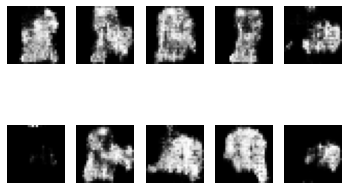

3201 [D loss: 0.693652, acc.: 51.95%] [G loss: 0.717572]
3202 [D loss: 0.695625, acc.: 53.52%] [G loss: 0.726106]
3203 [D loss: 0.694268, acc.: 48.05%] [G loss: 0.712456]
3204 [D loss: 0.694216, acc.: 51.56%] [G loss: 0.710293]
3205 [D loss: 0.695009, acc.: 53.52%] [G loss: 0.719474]
3206 [D loss: 0.692129, acc.: 48.83%] [G loss: 0.714814]
3207 [D loss: 0.697511, acc.: 47.66%] [G loss: 0.710537]
3208 [D loss: 0.688339, acc.: 53.12%] [G loss: 0.712918]
3209 [D loss: 0.698714, acc.: 51.17%] [G loss: 0.715634]
3210 [D loss: 0.685658, acc.: 55.47%] [G loss: 0.716374]
3211 [D loss: 0.694232, acc.: 49.22%] [G loss: 0.715256]
3212 [D loss: 0.695544, acc.: 51.56%] [G loss: 0.708467]
3213 [D loss: 0.696035, acc.: 46.09%] [G loss: 0.715993]
3214 [D loss: 0.704495, acc.: 44.14%] [G loss: 0.710502]
3215 [D loss: 0.691587, acc.: 53.12%] [G loss: 0.710950]
3216 [D loss: 0.699165, acc.: 44.92%] [G loss: 0.704730]
3217 [D loss: 0.697139, acc.: 51.56%] [G loss: 0.709499]
3218 [D loss: 0.694359, acc.: 5

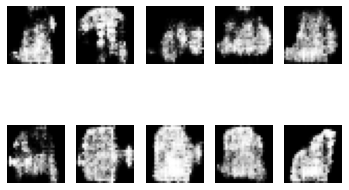

3401 [D loss: 0.697020, acc.: 51.95%] [G loss: 0.719831]
3402 [D loss: 0.687640, acc.: 54.69%] [G loss: 0.707332]
3403 [D loss: 0.686316, acc.: 57.42%] [G loss: 0.713335]
3404 [D loss: 0.692882, acc.: 51.17%] [G loss: 0.711730]
3405 [D loss: 0.689803, acc.: 53.91%] [G loss: 0.714624]
3406 [D loss: 0.692896, acc.: 52.73%] [G loss: 0.715525]
3407 [D loss: 0.698946, acc.: 50.78%] [G loss: 0.723646]
3408 [D loss: 0.694634, acc.: 51.17%] [G loss: 0.714807]
3409 [D loss: 0.690241, acc.: 54.30%] [G loss: 0.713276]
3410 [D loss: 0.689858, acc.: 51.56%] [G loss: 0.726107]
3411 [D loss: 0.698905, acc.: 51.56%] [G loss: 0.712180]
3412 [D loss: 0.700470, acc.: 46.48%] [G loss: 0.707200]
3413 [D loss: 0.703951, acc.: 46.09%] [G loss: 0.703895]
3414 [D loss: 0.694233, acc.: 48.05%] [G loss: 0.707936]
3415 [D loss: 0.692164, acc.: 53.52%] [G loss: 0.713615]
3416 [D loss: 0.694021, acc.: 52.34%] [G loss: 0.700328]
3417 [D loss: 0.691736, acc.: 52.34%] [G loss: 0.714186]
3418 [D loss: 0.696643, acc.: 4

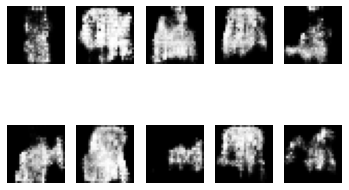

3601 [D loss: 0.701903, acc.: 47.66%] [G loss: 0.714266]
3602 [D loss: 0.701362, acc.: 50.78%] [G loss: 0.716882]
3603 [D loss: 0.698593, acc.: 49.22%] [G loss: 0.727504]
3604 [D loss: 0.696513, acc.: 52.34%] [G loss: 0.716043]
3605 [D loss: 0.701819, acc.: 46.48%] [G loss: 0.723735]
3606 [D loss: 0.696485, acc.: 49.22%] [G loss: 0.720984]
3607 [D loss: 0.691922, acc.: 50.39%] [G loss: 0.718830]
3608 [D loss: 0.693428, acc.: 51.95%] [G loss: 0.728563]
3609 [D loss: 0.691446, acc.: 55.47%] [G loss: 0.718473]
3610 [D loss: 0.689334, acc.: 57.81%] [G loss: 0.729850]
3611 [D loss: 0.694508, acc.: 51.17%] [G loss: 0.713335]
3612 [D loss: 0.685957, acc.: 52.34%] [G loss: 0.705053]
3613 [D loss: 0.700674, acc.: 51.17%] [G loss: 0.703652]
3614 [D loss: 0.688233, acc.: 53.12%] [G loss: 0.712497]
3615 [D loss: 0.702723, acc.: 44.53%] [G loss: 0.697300]
3616 [D loss: 0.694093, acc.: 50.39%] [G loss: 0.708825]
3617 [D loss: 0.689621, acc.: 53.91%] [G loss: 0.703853]
3618 [D loss: 0.706779, acc.: 4

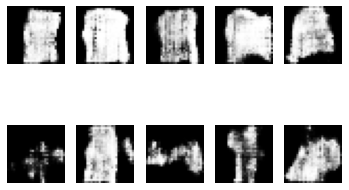

3801 [D loss: 0.693630, acc.: 50.39%] [G loss: 0.725463]
3802 [D loss: 0.686911, acc.: 56.64%] [G loss: 0.711272]
3803 [D loss: 0.695311, acc.: 51.56%] [G loss: 0.723655]
3804 [D loss: 0.694847, acc.: 51.95%] [G loss: 0.715133]
3805 [D loss: 0.692679, acc.: 51.56%] [G loss: 0.710010]
3806 [D loss: 0.694320, acc.: 48.44%] [G loss: 0.717534]
3807 [D loss: 0.702032, acc.: 44.92%] [G loss: 0.717009]
3808 [D loss: 0.694119, acc.: 52.73%] [G loss: 0.708749]
3809 [D loss: 0.700811, acc.: 44.14%] [G loss: 0.706210]
3810 [D loss: 0.702797, acc.: 46.88%] [G loss: 0.711499]
3811 [D loss: 0.700745, acc.: 44.92%] [G loss: 0.700875]
3812 [D loss: 0.692118, acc.: 54.69%] [G loss: 0.713734]
3813 [D loss: 0.699093, acc.: 45.31%] [G loss: 0.707121]
3814 [D loss: 0.694312, acc.: 53.12%] [G loss: 0.701796]
3815 [D loss: 0.689743, acc.: 52.34%] [G loss: 0.705818]
3816 [D loss: 0.692103, acc.: 52.34%] [G loss: 0.706673]
3817 [D loss: 0.692101, acc.: 52.34%] [G loss: 0.706552]
3818 [D loss: 0.693844, acc.: 5

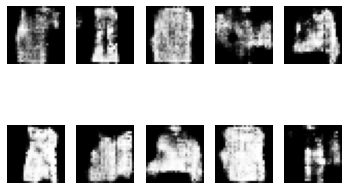

4001 [D loss: 0.695971, acc.: 49.22%] [G loss: 0.711868]
4002 [D loss: 0.697810, acc.: 46.48%] [G loss: 0.714620]
4003 [D loss: 0.702541, acc.: 42.97%] [G loss: 0.710591]
4004 [D loss: 0.698655, acc.: 48.05%] [G loss: 0.705269]
4005 [D loss: 0.697161, acc.: 44.14%] [G loss: 0.708776]
4006 [D loss: 0.698337, acc.: 47.66%] [G loss: 0.707982]
4007 [D loss: 0.702441, acc.: 42.58%] [G loss: 0.710391]
4008 [D loss: 0.699547, acc.: 42.19%] [G loss: 0.705768]
4009 [D loss: 0.696225, acc.: 50.78%] [G loss: 0.712933]
4010 [D loss: 0.698466, acc.: 48.83%] [G loss: 0.711679]
4011 [D loss: 0.700821, acc.: 44.53%] [G loss: 0.704659]
4012 [D loss: 0.699154, acc.: 46.88%] [G loss: 0.707178]
4013 [D loss: 0.695105, acc.: 49.61%] [G loss: 0.712497]
4014 [D loss: 0.696815, acc.: 51.95%] [G loss: 0.699366]
4015 [D loss: 0.703217, acc.: 42.58%] [G loss: 0.708952]
4016 [D loss: 0.696949, acc.: 49.61%] [G loss: 0.697272]
4017 [D loss: 0.697788, acc.: 46.09%] [G loss: 0.704174]
4018 [D loss: 0.700650, acc.: 4

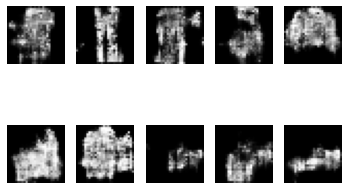

4201 [D loss: 0.703929, acc.: 42.58%] [G loss: 0.700678]
4202 [D loss: 0.698397, acc.: 50.00%] [G loss: 0.703095]
4203 [D loss: 0.694027, acc.: 50.00%] [G loss: 0.701149]
4204 [D loss: 0.694291, acc.: 48.44%] [G loss: 0.701775]
4205 [D loss: 0.701615, acc.: 44.53%] [G loss: 0.691405]
4206 [D loss: 0.697236, acc.: 48.83%] [G loss: 0.703397]
4207 [D loss: 0.693903, acc.: 52.73%] [G loss: 0.694953]
4208 [D loss: 0.701747, acc.: 37.11%] [G loss: 0.700658]
4209 [D loss: 0.700051, acc.: 46.48%] [G loss: 0.706942]
4210 [D loss: 0.700986, acc.: 44.53%] [G loss: 0.710405]
4211 [D loss: 0.697464, acc.: 46.48%] [G loss: 0.705709]
4212 [D loss: 0.697758, acc.: 45.70%] [G loss: 0.706450]
4213 [D loss: 0.695429, acc.: 47.27%] [G loss: 0.697955]
4214 [D loss: 0.695717, acc.: 46.88%] [G loss: 0.701009]
4215 [D loss: 0.694439, acc.: 47.66%] [G loss: 0.701022]
4216 [D loss: 0.701523, acc.: 42.58%] [G loss: 0.695823]
4217 [D loss: 0.700247, acc.: 44.92%] [G loss: 0.703829]
4218 [D loss: 0.694489, acc.: 5

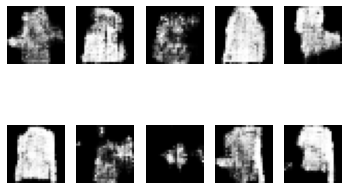

4401 [D loss: 0.703835, acc.: 42.97%] [G loss: 0.700524]
4402 [D loss: 0.695353, acc.: 50.00%] [G loss: 0.705449]
4403 [D loss: 0.698316, acc.: 46.48%] [G loss: 0.693208]
4404 [D loss: 0.698244, acc.: 43.36%] [G loss: 0.702196]
4405 [D loss: 0.697920, acc.: 45.31%] [G loss: 0.699500]
4406 [D loss: 0.696659, acc.: 46.88%] [G loss: 0.702887]
4407 [D loss: 0.701283, acc.: 42.19%] [G loss: 0.697852]
4408 [D loss: 0.699427, acc.: 45.31%] [G loss: 0.700108]
4409 [D loss: 0.696942, acc.: 46.88%] [G loss: 0.703294]
4410 [D loss: 0.693586, acc.: 51.17%] [G loss: 0.707061]
4411 [D loss: 0.694679, acc.: 48.05%] [G loss: 0.706598]
4412 [D loss: 0.693210, acc.: 51.95%] [G loss: 0.703036]
4413 [D loss: 0.698426, acc.: 48.83%] [G loss: 0.699530]
4414 [D loss: 0.696791, acc.: 47.27%] [G loss: 0.709094]
4415 [D loss: 0.696490, acc.: 44.53%] [G loss: 0.702576]
4416 [D loss: 0.697871, acc.: 46.09%] [G loss: 0.709441]
4417 [D loss: 0.692997, acc.: 50.00%] [G loss: 0.711925]
4418 [D loss: 0.696819, acc.: 4

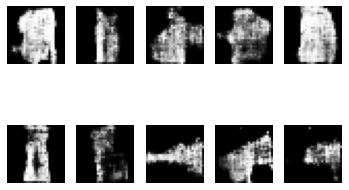

4601 [D loss: 0.696733, acc.: 48.83%] [G loss: 0.709933]
4602 [D loss: 0.693416, acc.: 52.73%] [G loss: 0.704179]
4603 [D loss: 0.698658, acc.: 44.14%] [G loss: 0.696362]
4604 [D loss: 0.699117, acc.: 45.70%] [G loss: 0.703298]
4605 [D loss: 0.694534, acc.: 48.05%] [G loss: 0.702868]
4606 [D loss: 0.695344, acc.: 49.22%] [G loss: 0.703361]
4607 [D loss: 0.694710, acc.: 47.66%] [G loss: 0.695955]
4608 [D loss: 0.695331, acc.: 49.22%] [G loss: 0.696560]
4609 [D loss: 0.701109, acc.: 44.53%] [G loss: 0.699484]
4610 [D loss: 0.696878, acc.: 46.09%] [G loss: 0.702032]
4611 [D loss: 0.693773, acc.: 51.17%] [G loss: 0.698498]
4612 [D loss: 0.698838, acc.: 46.09%] [G loss: 0.701407]
4613 [D loss: 0.692721, acc.: 52.34%] [G loss: 0.702154]
4614 [D loss: 0.696120, acc.: 46.88%] [G loss: 0.695100]
4615 [D loss: 0.699829, acc.: 44.14%] [G loss: 0.702415]
4616 [D loss: 0.694928, acc.: 48.83%] [G loss: 0.704069]
4617 [D loss: 0.695413, acc.: 50.00%] [G loss: 0.706166]
4618 [D loss: 0.692943, acc.: 5

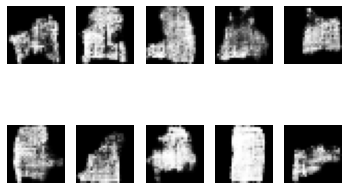

4801 [D loss: 0.694535, acc.: 47.66%] [G loss: 0.702198]
4802 [D loss: 0.697334, acc.: 48.44%] [G loss: 0.705828]
4803 [D loss: 0.698022, acc.: 46.88%] [G loss: 0.701837]
4804 [D loss: 0.692785, acc.: 53.12%] [G loss: 0.709249]
4805 [D loss: 0.697011, acc.: 44.14%] [G loss: 0.700031]
4806 [D loss: 0.696559, acc.: 47.66%] [G loss: 0.702404]
4807 [D loss: 0.695725, acc.: 48.83%] [G loss: 0.695673]
4808 [D loss: 0.694645, acc.: 48.44%] [G loss: 0.702299]
4809 [D loss: 0.698352, acc.: 41.02%] [G loss: 0.700929]
4810 [D loss: 0.695487, acc.: 45.70%] [G loss: 0.697177]
4811 [D loss: 0.691834, acc.: 53.12%] [G loss: 0.703105]
4812 [D loss: 0.696341, acc.: 49.61%] [G loss: 0.699156]
4813 [D loss: 0.696260, acc.: 45.31%] [G loss: 0.697087]
4814 [D loss: 0.697247, acc.: 46.88%] [G loss: 0.698815]
4815 [D loss: 0.693309, acc.: 51.95%] [G loss: 0.694853]
4816 [D loss: 0.695935, acc.: 50.00%] [G loss: 0.694472]
4817 [D loss: 0.697797, acc.: 43.36%] [G loss: 0.696245]
4818 [D loss: 0.695006, acc.: 5

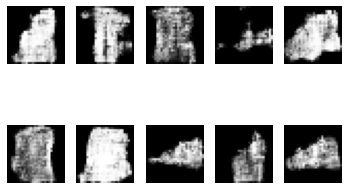

5001 [D loss: 0.695978, acc.: 46.88%] [G loss: 0.701350]
5002 [D loss: 0.694909, acc.: 51.95%] [G loss: 0.698783]
5003 [D loss: 0.694970, acc.: 46.09%] [G loss: 0.695853]
5004 [D loss: 0.694227, acc.: 47.66%] [G loss: 0.699737]
5005 [D loss: 0.697642, acc.: 42.97%] [G loss: 0.696644]
5006 [D loss: 0.697856, acc.: 45.31%] [G loss: 0.695104]
5007 [D loss: 0.696774, acc.: 44.14%] [G loss: 0.702141]
5008 [D loss: 0.696234, acc.: 47.66%] [G loss: 0.698793]
5009 [D loss: 0.694851, acc.: 48.05%] [G loss: 0.699343]
5010 [D loss: 0.693769, acc.: 51.17%] [G loss: 0.694999]
5011 [D loss: 0.696436, acc.: 47.27%] [G loss: 0.700792]
5012 [D loss: 0.696044, acc.: 46.88%] [G loss: 0.691917]
5013 [D loss: 0.696619, acc.: 44.92%] [G loss: 0.694099]
5014 [D loss: 0.694986, acc.: 49.61%] [G loss: 0.700216]
5015 [D loss: 0.693323, acc.: 45.70%] [G loss: 0.690512]
5016 [D loss: 0.695210, acc.: 47.66%] [G loss: 0.698504]
5017 [D loss: 0.693279, acc.: 52.34%] [G loss: 0.697897]
5018 [D loss: 0.696482, acc.: 4

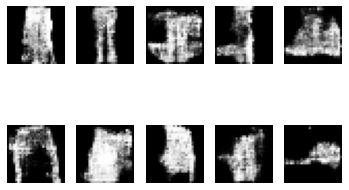

5201 [D loss: 0.691670, acc.: 50.39%] [G loss: 0.701087]
5202 [D loss: 0.696409, acc.: 46.48%] [G loss: 0.695806]
5203 [D loss: 0.694621, acc.: 46.88%] [G loss: 0.695147]
5204 [D loss: 0.693815, acc.: 49.61%] [G loss: 0.696290]
5205 [D loss: 0.692863, acc.: 51.95%] [G loss: 0.702320]
5206 [D loss: 0.691295, acc.: 53.52%] [G loss: 0.700949]
5207 [D loss: 0.694842, acc.: 48.05%] [G loss: 0.702609]
5208 [D loss: 0.693634, acc.: 47.27%] [G loss: 0.697662]
5209 [D loss: 0.695109, acc.: 50.78%] [G loss: 0.701214]
5210 [D loss: 0.695482, acc.: 46.88%] [G loss: 0.698871]
5211 [D loss: 0.694956, acc.: 44.92%] [G loss: 0.699546]
5212 [D loss: 0.694484, acc.: 47.66%] [G loss: 0.698901]
5213 [D loss: 0.697564, acc.: 43.75%] [G loss: 0.701652]
5214 [D loss: 0.697184, acc.: 46.48%] [G loss: 0.699080]
5215 [D loss: 0.693782, acc.: 49.61%] [G loss: 0.701398]
5216 [D loss: 0.694365, acc.: 47.66%] [G loss: 0.696030]
5217 [D loss: 0.698382, acc.: 45.31%] [G loss: 0.696703]
5218 [D loss: 0.696441, acc.: 5

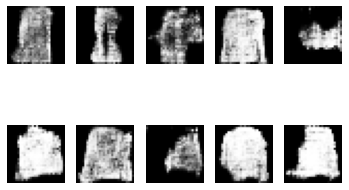

5401 [D loss: 0.694070, acc.: 48.83%] [G loss: 0.699905]
5402 [D loss: 0.692932, acc.: 48.44%] [G loss: 0.697570]
5403 [D loss: 0.694505, acc.: 48.05%] [G loss: 0.692501]
5404 [D loss: 0.692508, acc.: 51.95%] [G loss: 0.698561]
5405 [D loss: 0.697589, acc.: 45.70%] [G loss: 0.698179]
5406 [D loss: 0.696932, acc.: 44.53%] [G loss: 0.693287]
5407 [D loss: 0.695125, acc.: 48.83%] [G loss: 0.693826]
5408 [D loss: 0.693015, acc.: 48.44%] [G loss: 0.693776]
5409 [D loss: 0.691374, acc.: 51.95%] [G loss: 0.693035]
5410 [D loss: 0.696229, acc.: 44.92%] [G loss: 0.687967]
5411 [D loss: 0.696029, acc.: 45.70%] [G loss: 0.694168]
5412 [D loss: 0.695542, acc.: 43.36%] [G loss: 0.694686]
5413 [D loss: 0.695060, acc.: 50.00%] [G loss: 0.692701]
5414 [D loss: 0.697515, acc.: 46.48%] [G loss: 0.698415]
5415 [D loss: 0.694203, acc.: 45.31%] [G loss: 0.691884]
5416 [D loss: 0.693540, acc.: 51.95%] [G loss: 0.695724]
5417 [D loss: 0.694679, acc.: 48.83%] [G loss: 0.697211]
5418 [D loss: 0.693529, acc.: 4

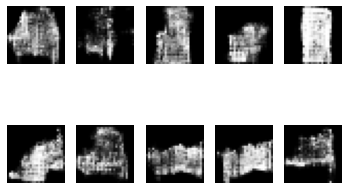

5601 [D loss: 0.694731, acc.: 48.05%] [G loss: 0.693932]
5602 [D loss: 0.697235, acc.: 45.70%] [G loss: 0.693365]
5603 [D loss: 0.694329, acc.: 47.27%] [G loss: 0.695265]
5604 [D loss: 0.694591, acc.: 46.09%] [G loss: 0.696118]
5605 [D loss: 0.694683, acc.: 48.44%] [G loss: 0.697505]
5606 [D loss: 0.692323, acc.: 53.12%] [G loss: 0.697122]
5607 [D loss: 0.695015, acc.: 46.09%] [G loss: 0.701719]
5608 [D loss: 0.693610, acc.: 49.22%] [G loss: 0.706126]
5609 [D loss: 0.692620, acc.: 50.00%] [G loss: 0.697919]
5610 [D loss: 0.693004, acc.: 46.48%] [G loss: 0.708760]
5611 [D loss: 0.692060, acc.: 50.39%] [G loss: 0.701468]
5612 [D loss: 0.692526, acc.: 50.00%] [G loss: 0.701865]
5613 [D loss: 0.696707, acc.: 44.92%] [G loss: 0.698616]
5614 [D loss: 0.694864, acc.: 49.22%] [G loss: 0.699348]
5615 [D loss: 0.693431, acc.: 50.39%] [G loss: 0.700871]
5616 [D loss: 0.693717, acc.: 51.17%] [G loss: 0.700017]
5617 [D loss: 0.694869, acc.: 45.70%] [G loss: 0.701849]
5618 [D loss: 0.695946, acc.: 4

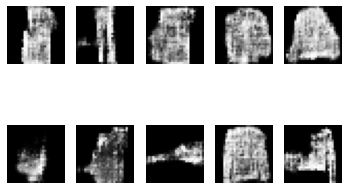

5801 [D loss: 0.693975, acc.: 49.61%] [G loss: 0.699740]
5802 [D loss: 0.694398, acc.: 49.61%] [G loss: 0.697876]
5803 [D loss: 0.692497, acc.: 54.69%] [G loss: 0.701749]
5804 [D loss: 0.695596, acc.: 45.70%] [G loss: 0.698347]
5805 [D loss: 0.692936, acc.: 54.69%] [G loss: 0.696629]
5806 [D loss: 0.695002, acc.: 47.66%] [G loss: 0.695354]
5807 [D loss: 0.697320, acc.: 46.88%] [G loss: 0.698641]
5808 [D loss: 0.693736, acc.: 49.61%] [G loss: 0.697994]
5809 [D loss: 0.694894, acc.: 50.00%] [G loss: 0.698813]
5810 [D loss: 0.696174, acc.: 47.66%] [G loss: 0.697588]
5811 [D loss: 0.694148, acc.: 46.48%] [G loss: 0.701525]
5812 [D loss: 0.693861, acc.: 53.91%] [G loss: 0.695160]
5813 [D loss: 0.690991, acc.: 54.69%] [G loss: 0.699077]
5814 [D loss: 0.692885, acc.: 48.83%] [G loss: 0.702562]
5815 [D loss: 0.694143, acc.: 49.22%] [G loss: 0.700421]
5816 [D loss: 0.696048, acc.: 46.88%] [G loss: 0.699779]
5817 [D loss: 0.693996, acc.: 48.83%] [G loss: 0.698072]
5818 [D loss: 0.694121, acc.: 4

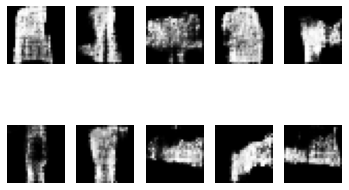

6001 [D loss: 0.694779, acc.: 47.27%] [G loss: 0.692427]
6002 [D loss: 0.694599, acc.: 48.05%] [G loss: 0.697367]
6003 [D loss: 0.692815, acc.: 53.52%] [G loss: 0.694845]
6004 [D loss: 0.693719, acc.: 51.17%] [G loss: 0.699914]
6005 [D loss: 0.693397, acc.: 50.78%] [G loss: 0.700313]
6006 [D loss: 0.693435, acc.: 46.88%] [G loss: 0.700212]
6007 [D loss: 0.688986, acc.: 60.16%] [G loss: 0.706709]
6008 [D loss: 0.694578, acc.: 48.05%] [G loss: 0.699938]
6009 [D loss: 0.693737, acc.: 53.91%] [G loss: 0.697610]
6010 [D loss: 0.692703, acc.: 49.22%] [G loss: 0.695756]
6011 [D loss: 0.693949, acc.: 47.27%] [G loss: 0.695220]
6012 [D loss: 0.694933, acc.: 44.14%] [G loss: 0.693206]
6013 [D loss: 0.692807, acc.: 53.12%] [G loss: 0.693917]
6014 [D loss: 0.695577, acc.: 47.66%] [G loss: 0.697184]
6015 [D loss: 0.694575, acc.: 51.17%] [G loss: 0.695175]
6016 [D loss: 0.694355, acc.: 48.44%] [G loss: 0.689706]
6017 [D loss: 0.695823, acc.: 48.44%] [G loss: 0.692626]
6018 [D loss: 0.695529, acc.: 4

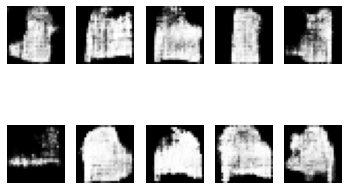

6201 [D loss: 0.694835, acc.: 45.31%] [G loss: 0.697778]
6202 [D loss: 0.693981, acc.: 48.44%] [G loss: 0.697269]
6203 [D loss: 0.695656, acc.: 47.27%] [G loss: 0.701166]
6204 [D loss: 0.690812, acc.: 53.91%] [G loss: 0.706593]
6205 [D loss: 0.693724, acc.: 51.17%] [G loss: 0.704326]
6206 [D loss: 0.694019, acc.: 51.56%] [G loss: 0.706898]
6207 [D loss: 0.693969, acc.: 52.34%] [G loss: 0.700432]
6208 [D loss: 0.696038, acc.: 44.53%] [G loss: 0.701207]
6209 [D loss: 0.696221, acc.: 48.83%] [G loss: 0.697966]
6210 [D loss: 0.696792, acc.: 44.53%] [G loss: 0.696637]
6211 [D loss: 0.696494, acc.: 45.31%] [G loss: 0.699197]
6212 [D loss: 0.695430, acc.: 46.88%] [G loss: 0.701578]
6213 [D loss: 0.692931, acc.: 54.30%] [G loss: 0.699598]
6214 [D loss: 0.693725, acc.: 51.56%] [G loss: 0.696083]
6215 [D loss: 0.694424, acc.: 46.48%] [G loss: 0.696900]
6216 [D loss: 0.694653, acc.: 51.17%] [G loss: 0.696874]
6217 [D loss: 0.695088, acc.: 46.09%] [G loss: 0.697185]
6218 [D loss: 0.694600, acc.: 4

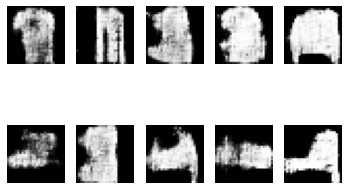

6401 [D loss: 0.694962, acc.: 49.61%] [G loss: 0.699854]
6402 [D loss: 0.692347, acc.: 51.95%] [G loss: 0.701613]
6403 [D loss: 0.693267, acc.: 46.48%] [G loss: 0.703229]
6404 [D loss: 0.694888, acc.: 47.27%] [G loss: 0.702403]
6405 [D loss: 0.694561, acc.: 45.31%] [G loss: 0.699663]
6406 [D loss: 0.692920, acc.: 51.56%] [G loss: 0.699144]
6407 [D loss: 0.696416, acc.: 46.88%] [G loss: 0.696577]
6408 [D loss: 0.697227, acc.: 40.23%] [G loss: 0.698785]
6409 [D loss: 0.695725, acc.: 41.02%] [G loss: 0.694850]
6410 [D loss: 0.692529, acc.: 51.17%] [G loss: 0.699348]
6411 [D loss: 0.692193, acc.: 53.52%] [G loss: 0.700347]
6412 [D loss: 0.693392, acc.: 50.39%] [G loss: 0.697010]
6413 [D loss: 0.694628, acc.: 48.05%] [G loss: 0.696787]
6414 [D loss: 0.693821, acc.: 50.78%] [G loss: 0.696792]
6415 [D loss: 0.696770, acc.: 44.92%] [G loss: 0.690276]
6416 [D loss: 0.695623, acc.: 42.19%] [G loss: 0.696067]
6417 [D loss: 0.696823, acc.: 42.58%] [G loss: 0.699176]
6418 [D loss: 0.694971, acc.: 4

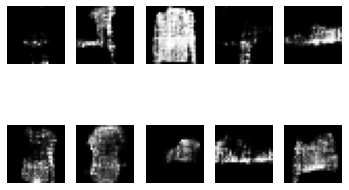

6601 [D loss: 0.697136, acc.: 45.31%] [G loss: 0.696919]
6602 [D loss: 0.694133, acc.: 46.09%] [G loss: 0.698277]
6603 [D loss: 0.690596, acc.: 54.30%] [G loss: 0.703718]
6604 [D loss: 0.690867, acc.: 56.25%] [G loss: 0.702415]
6605 [D loss: 0.693473, acc.: 48.05%] [G loss: 0.697896]
6606 [D loss: 0.692702, acc.: 50.00%] [G loss: 0.696257]
6607 [D loss: 0.695751, acc.: 51.17%] [G loss: 0.692354]
6608 [D loss: 0.695177, acc.: 49.22%] [G loss: 0.692585]
6609 [D loss: 0.695784, acc.: 47.66%] [G loss: 0.691762]
6610 [D loss: 0.697912, acc.: 40.62%] [G loss: 0.697486]
6611 [D loss: 0.693729, acc.: 46.48%] [G loss: 0.699793]
6612 [D loss: 0.694119, acc.: 50.00%] [G loss: 0.701079]
6613 [D loss: 0.692235, acc.: 50.39%] [G loss: 0.710269]
6614 [D loss: 0.690575, acc.: 51.95%] [G loss: 0.704774]
6615 [D loss: 0.692619, acc.: 49.61%] [G loss: 0.706667]
6616 [D loss: 0.692135, acc.: 52.73%] [G loss: 0.706221]
6617 [D loss: 0.694803, acc.: 48.83%] [G loss: 0.699611]
6618 [D loss: 0.692327, acc.: 5

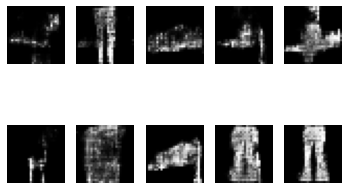

6801 [D loss: 0.697284, acc.: 42.58%] [G loss: 0.694632]
6802 [D loss: 0.695508, acc.: 46.09%] [G loss: 0.698826]
6803 [D loss: 0.692669, acc.: 52.73%] [G loss: 0.699596]
6804 [D loss: 0.692468, acc.: 51.95%] [G loss: 0.702355]
6805 [D loss: 0.692202, acc.: 49.61%] [G loss: 0.701843]
6806 [D loss: 0.691550, acc.: 52.34%] [G loss: 0.698546]
6807 [D loss: 0.693288, acc.: 49.22%] [G loss: 0.691897]
6808 [D loss: 0.695690, acc.: 46.88%] [G loss: 0.691172]
6809 [D loss: 0.695280, acc.: 47.66%] [G loss: 0.690211]
6810 [D loss: 0.695264, acc.: 48.44%] [G loss: 0.693081]
6811 [D loss: 0.696304, acc.: 44.53%] [G loss: 0.694936]
6812 [D loss: 0.693980, acc.: 51.17%] [G loss: 0.699111]
6813 [D loss: 0.693764, acc.: 48.83%] [G loss: 0.698617]
6814 [D loss: 0.692373, acc.: 52.34%] [G loss: 0.705229]
6815 [D loss: 0.689839, acc.: 56.25%] [G loss: 0.707050]
6816 [D loss: 0.691098, acc.: 55.47%] [G loss: 0.707287]
6817 [D loss: 0.692858, acc.: 50.78%] [G loss: 0.713508]
6818 [D loss: 0.693178, acc.: 4

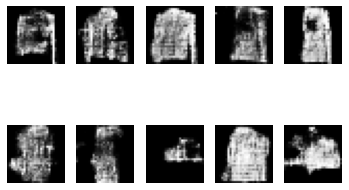

7001 [D loss: 0.693056, acc.: 50.39%] [G loss: 0.699478]
7002 [D loss: 0.692404, acc.: 52.34%] [G loss: 0.693810]
7003 [D loss: 0.694296, acc.: 45.70%] [G loss: 0.692743]
7004 [D loss: 0.695122, acc.: 44.53%] [G loss: 0.694084]
7005 [D loss: 0.694531, acc.: 45.31%] [G loss: 0.692622]
7006 [D loss: 0.694516, acc.: 45.31%] [G loss: 0.693053]
7007 [D loss: 0.695398, acc.: 43.36%] [G loss: 0.693009]
7008 [D loss: 0.694722, acc.: 46.48%] [G loss: 0.697257]
7009 [D loss: 0.694658, acc.: 46.88%] [G loss: 0.698462]
7010 [D loss: 0.693497, acc.: 49.61%] [G loss: 0.702344]
7011 [D loss: 0.692282, acc.: 50.00%] [G loss: 0.702782]
7012 [D loss: 0.693171, acc.: 50.00%] [G loss: 0.701181]
7013 [D loss: 0.694389, acc.: 48.44%] [G loss: 0.698773]
7014 [D loss: 0.693855, acc.: 49.61%] [G loss: 0.699770]
7015 [D loss: 0.694194, acc.: 46.48%] [G loss: 0.699362]
7016 [D loss: 0.693660, acc.: 50.78%] [G loss: 0.693403]
7017 [D loss: 0.695527, acc.: 44.14%] [G loss: 0.694257]
7018 [D loss: 0.695421, acc.: 4

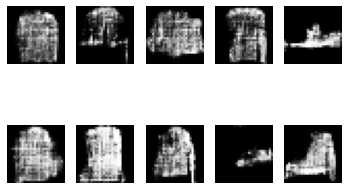

7201 [D loss: 0.697246, acc.: 39.06%] [G loss: 0.694488]
7202 [D loss: 0.692795, acc.: 50.78%] [G loss: 0.690884]
7203 [D loss: 0.695876, acc.: 44.53%] [G loss: 0.697123]
7204 [D loss: 0.693342, acc.: 51.56%] [G loss: 0.694852]
7205 [D loss: 0.693450, acc.: 51.56%] [G loss: 0.696913]
7206 [D loss: 0.692153, acc.: 54.69%] [G loss: 0.697338]
7207 [D loss: 0.693231, acc.: 49.22%] [G loss: 0.693712]
7208 [D loss: 0.694441, acc.: 48.83%] [G loss: 0.690600]
7209 [D loss: 0.694631, acc.: 43.75%] [G loss: 0.689956]
7210 [D loss: 0.696153, acc.: 42.19%] [G loss: 0.686828]
7211 [D loss: 0.695366, acc.: 46.09%] [G loss: 0.693047]
7212 [D loss: 0.695824, acc.: 49.22%] [G loss: 0.691292]
7213 [D loss: 0.695655, acc.: 44.14%] [G loss: 0.694810]
7214 [D loss: 0.693435, acc.: 50.39%] [G loss: 0.697414]
7215 [D loss: 0.692024, acc.: 52.73%] [G loss: 0.699270]
7216 [D loss: 0.692463, acc.: 49.61%] [G loss: 0.699904]
7217 [D loss: 0.692783, acc.: 50.39%] [G loss: 0.699840]
7218 [D loss: 0.693549, acc.: 4

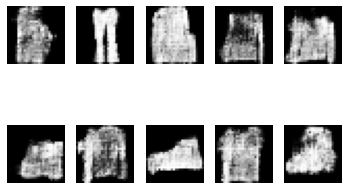

7401 [D loss: 0.694742, acc.: 49.61%] [G loss: 0.694961]
7402 [D loss: 0.692300, acc.: 52.34%] [G loss: 0.696674]
7403 [D loss: 0.693191, acc.: 48.44%] [G loss: 0.698021]
7404 [D loss: 0.693334, acc.: 49.61%] [G loss: 0.698006]
7405 [D loss: 0.694024, acc.: 49.61%] [G loss: 0.697073]
7406 [D loss: 0.694676, acc.: 48.83%] [G loss: 0.693568]
7407 [D loss: 0.693930, acc.: 48.05%] [G loss: 0.693699]
7408 [D loss: 0.693523, acc.: 46.88%] [G loss: 0.696314]
7409 [D loss: 0.693330, acc.: 51.17%] [G loss: 0.697085]
7410 [D loss: 0.694080, acc.: 50.78%] [G loss: 0.695444]
7411 [D loss: 0.693311, acc.: 48.44%] [G loss: 0.695073]
7412 [D loss: 0.693839, acc.: 47.66%] [G loss: 0.696048]
7413 [D loss: 0.692557, acc.: 51.56%] [G loss: 0.694093]
7414 [D loss: 0.693714, acc.: 48.05%] [G loss: 0.692309]
7415 [D loss: 0.693901, acc.: 50.00%] [G loss: 0.692664]
7416 [D loss: 0.692620, acc.: 50.78%] [G loss: 0.695133]
7417 [D loss: 0.692688, acc.: 51.17%] [G loss: 0.692607]
7418 [D loss: 0.693827, acc.: 4

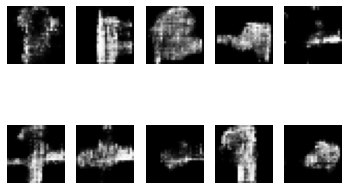

7601 [D loss: 0.695458, acc.: 43.36%] [G loss: 0.699611]
7602 [D loss: 0.694213, acc.: 45.31%] [G loss: 0.697315]
7603 [D loss: 0.693551, acc.: 49.61%] [G loss: 0.694381]
7604 [D loss: 0.692521, acc.: 50.39%] [G loss: 0.699900]
7605 [D loss: 0.693287, acc.: 51.95%] [G loss: 0.699103]
7606 [D loss: 0.693239, acc.: 50.39%] [G loss: 0.699183]
7607 [D loss: 0.695370, acc.: 46.09%] [G loss: 0.696529]
7608 [D loss: 0.696123, acc.: 41.02%] [G loss: 0.694298]
7609 [D loss: 0.693606, acc.: 48.83%] [G loss: 0.694951]
7610 [D loss: 0.694623, acc.: 45.31%] [G loss: 0.697979]
7611 [D loss: 0.693440, acc.: 51.17%] [G loss: 0.700480]
7612 [D loss: 0.692979, acc.: 53.91%] [G loss: 0.702636]
7613 [D loss: 0.692108, acc.: 58.20%] [G loss: 0.702235]
7614 [D loss: 0.691234, acc.: 56.64%] [G loss: 0.702686]
7615 [D loss: 0.693301, acc.: 49.22%] [G loss: 0.703930]
7616 [D loss: 0.693421, acc.: 48.83%] [G loss: 0.698259]
7617 [D loss: 0.696119, acc.: 41.41%] [G loss: 0.698144]
7618 [D loss: 0.695433, acc.: 4

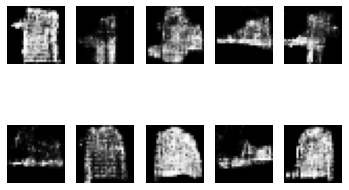

7801 [D loss: 0.691839, acc.: 53.52%] [G loss: 0.699409]
7802 [D loss: 0.693826, acc.: 49.22%] [G loss: 0.697372]
7803 [D loss: 0.692077, acc.: 57.81%] [G loss: 0.695582]
7804 [D loss: 0.694761, acc.: 42.97%] [G loss: 0.693399]
7805 [D loss: 0.693307, acc.: 49.22%] [G loss: 0.693637]
7806 [D loss: 0.694231, acc.: 51.17%] [G loss: 0.689999]
7807 [D loss: 0.694103, acc.: 46.48%] [G loss: 0.692719]
7808 [D loss: 0.693178, acc.: 51.17%] [G loss: 0.690729]
7809 [D loss: 0.694710, acc.: 48.05%] [G loss: 0.694545]
7810 [D loss: 0.693650, acc.: 49.61%] [G loss: 0.693451]
7811 [D loss: 0.693004, acc.: 51.56%] [G loss: 0.694613]
7812 [D loss: 0.691666, acc.: 55.08%] [G loss: 0.696592]
7813 [D loss: 0.693794, acc.: 50.39%] [G loss: 0.697941]
7814 [D loss: 0.692268, acc.: 51.56%] [G loss: 0.699079]
7815 [D loss: 0.694042, acc.: 48.05%] [G loss: 0.697014]
7816 [D loss: 0.693444, acc.: 49.22%] [G loss: 0.697004]
7817 [D loss: 0.694505, acc.: 50.00%] [G loss: 0.693328]
7818 [D loss: 0.694741, acc.: 4

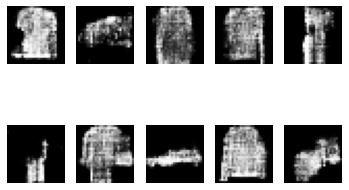

8001 [D loss: 0.694598, acc.: 48.44%] [G loss: 0.697078]
8002 [D loss: 0.694368, acc.: 48.05%] [G loss: 0.696331]
8003 [D loss: 0.695572, acc.: 41.02%] [G loss: 0.696305]
8004 [D loss: 0.694015, acc.: 48.83%] [G loss: 0.696384]
8005 [D loss: 0.694901, acc.: 43.75%] [G loss: 0.696728]
8006 [D loss: 0.693432, acc.: 48.44%] [G loss: 0.698711]
8007 [D loss: 0.692432, acc.: 53.12%] [G loss: 0.696637]
8008 [D loss: 0.693261, acc.: 52.73%] [G loss: 0.696288]
8009 [D loss: 0.693061, acc.: 51.17%] [G loss: 0.695196]
8010 [D loss: 0.693298, acc.: 49.22%] [G loss: 0.691207]
8011 [D loss: 0.693821, acc.: 47.27%] [G loss: 0.692537]
8012 [D loss: 0.694076, acc.: 46.09%] [G loss: 0.692972]
8013 [D loss: 0.693912, acc.: 47.27%] [G loss: 0.692802]
8014 [D loss: 0.694288, acc.: 46.48%] [G loss: 0.694304]
8015 [D loss: 0.693783, acc.: 47.66%] [G loss: 0.695714]
8016 [D loss: 0.694153, acc.: 49.22%] [G loss: 0.696574]
8017 [D loss: 0.693216, acc.: 50.78%] [G loss: 0.699135]
8018 [D loss: 0.690116, acc.: 5

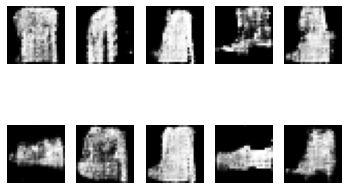

8201 [D loss: 0.694116, acc.: 47.27%] [G loss: 0.697836]
8202 [D loss: 0.692721, acc.: 51.17%] [G loss: 0.697990]
8203 [D loss: 0.693506, acc.: 51.17%] [G loss: 0.696197]
8204 [D loss: 0.692261, acc.: 53.12%] [G loss: 0.696931]
8205 [D loss: 0.693368, acc.: 49.22%] [G loss: 0.698258]
8206 [D loss: 0.694346, acc.: 46.09%] [G loss: 0.696298]
8207 [D loss: 0.693343, acc.: 51.17%] [G loss: 0.696048]
8208 [D loss: 0.693264, acc.: 50.00%] [G loss: 0.696136]
8209 [D loss: 0.693355, acc.: 49.22%] [G loss: 0.696278]
8210 [D loss: 0.693148, acc.: 48.44%] [G loss: 0.696902]
8211 [D loss: 0.692781, acc.: 50.39%] [G loss: 0.695580]
8212 [D loss: 0.694192, acc.: 48.83%] [G loss: 0.692342]
8213 [D loss: 0.693205, acc.: 48.44%] [G loss: 0.695733]
8214 [D loss: 0.694638, acc.: 44.92%] [G loss: 0.693951]
8215 [D loss: 0.694835, acc.: 44.53%] [G loss: 0.693271]
8216 [D loss: 0.694940, acc.: 45.70%] [G loss: 0.695421]
8217 [D loss: 0.693645, acc.: 49.22%] [G loss: 0.693948]
8218 [D loss: 0.693720, acc.: 4

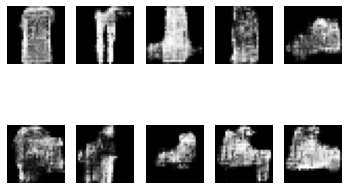

8401 [D loss: 0.693960, acc.: 47.27%] [G loss: 0.695378]
8402 [D loss: 0.694316, acc.: 46.88%] [G loss: 0.696050]
8403 [D loss: 0.693212, acc.: 50.00%] [G loss: 0.694498]
8404 [D loss: 0.693417, acc.: 51.56%] [G loss: 0.692960]
8405 [D loss: 0.693937, acc.: 48.83%] [G loss: 0.694091]
8406 [D loss: 0.694860, acc.: 45.70%] [G loss: 0.692711]
8407 [D loss: 0.693749, acc.: 49.22%] [G loss: 0.693537]
8408 [D loss: 0.693818, acc.: 45.31%] [G loss: 0.694127]
8409 [D loss: 0.694274, acc.: 45.70%] [G loss: 0.692730]
8410 [D loss: 0.694448, acc.: 43.75%] [G loss: 0.695913]
8411 [D loss: 0.693279, acc.: 50.00%] [G loss: 0.694836]
8412 [D loss: 0.693766, acc.: 48.44%] [G loss: 0.696573]
8413 [D loss: 0.694338, acc.: 46.09%] [G loss: 0.696576]
8414 [D loss: 0.693660, acc.: 49.22%] [G loss: 0.696437]
8415 [D loss: 0.695622, acc.: 42.97%] [G loss: 0.696543]
8416 [D loss: 0.694226, acc.: 44.92%] [G loss: 0.694868]
8417 [D loss: 0.692725, acc.: 48.83%] [G loss: 0.694979]
8418 [D loss: 0.693907, acc.: 4

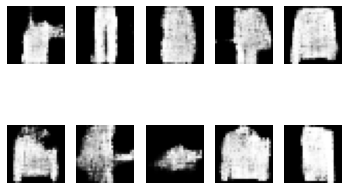

8601 [D loss: 0.693342, acc.: 50.00%] [G loss: 0.698273]
8602 [D loss: 0.691629, acc.: 55.86%] [G loss: 0.698577]
8603 [D loss: 0.692584, acc.: 51.95%] [G loss: 0.701207]
8604 [D loss: 0.691443, acc.: 59.77%] [G loss: 0.701753]
8605 [D loss: 0.693011, acc.: 55.47%] [G loss: 0.701752]
8606 [D loss: 0.692326, acc.: 49.22%] [G loss: 0.699106]
8607 [D loss: 0.693292, acc.: 49.61%] [G loss: 0.697291]
8608 [D loss: 0.694784, acc.: 44.14%] [G loss: 0.694639]
8609 [D loss: 0.695341, acc.: 44.53%] [G loss: 0.692894]
8610 [D loss: 0.694674, acc.: 42.19%] [G loss: 0.696044]
8611 [D loss: 0.694153, acc.: 48.44%] [G loss: 0.698085]
8612 [D loss: 0.691365, acc.: 58.98%] [G loss: 0.699515]
8613 [D loss: 0.690589, acc.: 57.03%] [G loss: 0.702386]
8614 [D loss: 0.690729, acc.: 54.30%] [G loss: 0.698722]
8615 [D loss: 0.693231, acc.: 50.00%] [G loss: 0.696331]
8616 [D loss: 0.694210, acc.: 50.00%] [G loss: 0.690675]
8617 [D loss: 0.696719, acc.: 44.53%] [G loss: 0.690074]
8618 [D loss: 0.694508, acc.: 4

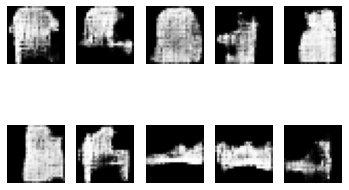

8801 [D loss: 0.694979, acc.: 44.92%] [G loss: 0.690777]
8802 [D loss: 0.693681, acc.: 50.00%] [G loss: 0.690251]
8803 [D loss: 0.693577, acc.: 47.27%] [G loss: 0.690821]
8804 [D loss: 0.693966, acc.: 48.83%] [G loss: 0.692885]
8805 [D loss: 0.693391, acc.: 50.00%] [G loss: 0.694143]
8806 [D loss: 0.692930, acc.: 49.22%] [G loss: 0.696384]
8807 [D loss: 0.692964, acc.: 50.78%] [G loss: 0.695989]
8808 [D loss: 0.692514, acc.: 51.56%] [G loss: 0.696361]
8809 [D loss: 0.693525, acc.: 49.22%] [G loss: 0.698850]
8810 [D loss: 0.692292, acc.: 50.00%] [G loss: 0.696141]
8811 [D loss: 0.693599, acc.: 48.05%] [G loss: 0.694865]
8812 [D loss: 0.693119, acc.: 48.05%] [G loss: 0.695152]
8813 [D loss: 0.694807, acc.: 48.44%] [G loss: 0.696939]
8814 [D loss: 0.693202, acc.: 49.61%] [G loss: 0.693166]
8815 [D loss: 0.694721, acc.: 46.09%] [G loss: 0.691709]
8816 [D loss: 0.694546, acc.: 45.70%] [G loss: 0.693342]
8817 [D loss: 0.694131, acc.: 48.05%] [G loss: 0.693603]
8818 [D loss: 0.693250, acc.: 5

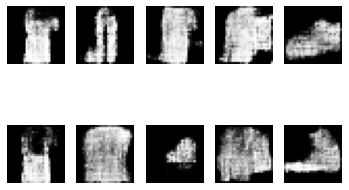

9001 [D loss: 0.693403, acc.: 51.17%] [G loss: 0.696817]
9002 [D loss: 0.692753, acc.: 51.56%] [G loss: 0.696625]
9003 [D loss: 0.693278, acc.: 43.75%] [G loss: 0.695554]
9004 [D loss: 0.693812, acc.: 48.83%] [G loss: 0.696051]
9005 [D loss: 0.693993, acc.: 46.09%] [G loss: 0.693126]
9006 [D loss: 0.694087, acc.: 44.92%] [G loss: 0.694872]
9007 [D loss: 0.693959, acc.: 47.27%] [G loss: 0.694985]
9008 [D loss: 0.695025, acc.: 41.80%] [G loss: 0.694284]
9009 [D loss: 0.693684, acc.: 46.48%] [G loss: 0.695011]
9010 [D loss: 0.693400, acc.: 45.31%] [G loss: 0.694067]
9011 [D loss: 0.692643, acc.: 52.73%] [G loss: 0.694988]
9012 [D loss: 0.692266, acc.: 51.17%] [G loss: 0.696647]
9013 [D loss: 0.692888, acc.: 48.05%] [G loss: 0.691990]
9014 [D loss: 0.692094, acc.: 52.34%] [G loss: 0.694281]
9015 [D loss: 0.693317, acc.: 50.78%] [G loss: 0.693175]
9016 [D loss: 0.692961, acc.: 49.22%] [G loss: 0.694276]
9017 [D loss: 0.693081, acc.: 49.61%] [G loss: 0.692726]
9018 [D loss: 0.694275, acc.: 4

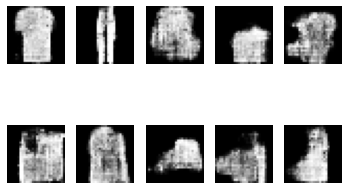

9201 [D loss: 0.691397, acc.: 58.59%] [G loss: 0.699533]
9202 [D loss: 0.692300, acc.: 55.08%] [G loss: 0.696736]
9203 [D loss: 0.693902, acc.: 48.44%] [G loss: 0.697256]
9204 [D loss: 0.694445, acc.: 48.83%] [G loss: 0.693602]
9205 [D loss: 0.693426, acc.: 50.78%] [G loss: 0.695464]
9206 [D loss: 0.695144, acc.: 44.14%] [G loss: 0.695306]
9207 [D loss: 0.694200, acc.: 43.36%] [G loss: 0.693032]
9208 [D loss: 0.693872, acc.: 47.27%] [G loss: 0.693072]
9209 [D loss: 0.692637, acc.: 51.17%] [G loss: 0.694763]
9210 [D loss: 0.692889, acc.: 48.44%] [G loss: 0.694338]
9211 [D loss: 0.693230, acc.: 51.17%] [G loss: 0.694761]
9212 [D loss: 0.692630, acc.: 57.42%] [G loss: 0.694514]
9213 [D loss: 0.692358, acc.: 50.39%] [G loss: 0.692984]
9214 [D loss: 0.692357, acc.: 53.91%] [G loss: 0.695004]
9215 [D loss: 0.693129, acc.: 52.34%] [G loss: 0.692283]
9216 [D loss: 0.692680, acc.: 49.61%] [G loss: 0.695097]
9217 [D loss: 0.694365, acc.: 46.88%] [G loss: 0.693623]
9218 [D loss: 0.694246, acc.: 4

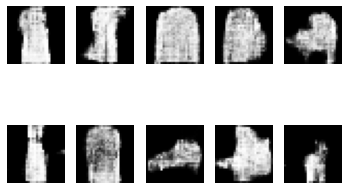

9401 [D loss: 0.692917, acc.: 53.12%] [G loss: 0.698955]
9402 [D loss: 0.693063, acc.: 49.22%] [G loss: 0.696568]
9403 [D loss: 0.694072, acc.: 44.53%] [G loss: 0.694924]
9404 [D loss: 0.692826, acc.: 50.78%] [G loss: 0.694994]
9405 [D loss: 0.694777, acc.: 42.19%] [G loss: 0.693747]
9406 [D loss: 0.694361, acc.: 48.05%] [G loss: 0.692753]
9407 [D loss: 0.694176, acc.: 44.92%] [G loss: 0.693717]
9408 [D loss: 0.693021, acc.: 50.39%] [G loss: 0.693997]
9409 [D loss: 0.693310, acc.: 51.17%] [G loss: 0.693418]
9410 [D loss: 0.692811, acc.: 50.39%] [G loss: 0.695671]
9411 [D loss: 0.692068, acc.: 57.81%] [G loss: 0.696923]
9412 [D loss: 0.691202, acc.: 57.81%] [G loss: 0.696666]
9413 [D loss: 0.693264, acc.: 53.12%] [G loss: 0.695456]
9414 [D loss: 0.693161, acc.: 50.78%] [G loss: 0.695039]
9415 [D loss: 0.692891, acc.: 51.56%] [G loss: 0.692455]
9416 [D loss: 0.694789, acc.: 45.31%] [G loss: 0.691631]
9417 [D loss: 0.694552, acc.: 41.41%] [G loss: 0.691930]
9418 [D loss: 0.694546, acc.: 4

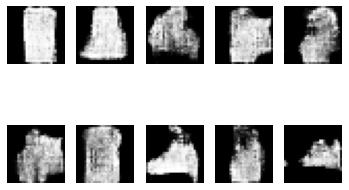

9601 [D loss: 0.693155, acc.: 52.73%] [G loss: 0.692472]
9602 [D loss: 0.693231, acc.: 51.95%] [G loss: 0.693902]
9603 [D loss: 0.693061, acc.: 50.00%] [G loss: 0.693114]
9604 [D loss: 0.693933, acc.: 46.09%] [G loss: 0.694137]
9605 [D loss: 0.693674, acc.: 47.27%] [G loss: 0.694437]
9606 [D loss: 0.692874, acc.: 52.73%] [G loss: 0.693402]
9607 [D loss: 0.693318, acc.: 47.66%] [G loss: 0.693049]
9608 [D loss: 0.693112, acc.: 53.52%] [G loss: 0.694446]
9609 [D loss: 0.693390, acc.: 50.39%] [G loss: 0.694428]
9610 [D loss: 0.693530, acc.: 47.27%] [G loss: 0.694872]
9611 [D loss: 0.693588, acc.: 44.53%] [G loss: 0.695143]
9612 [D loss: 0.694118, acc.: 48.05%] [G loss: 0.694498]
9613 [D loss: 0.694219, acc.: 44.92%] [G loss: 0.696227]
9614 [D loss: 0.693267, acc.: 50.00%] [G loss: 0.694844]
9615 [D loss: 0.693635, acc.: 44.14%] [G loss: 0.694574]
9616 [D loss: 0.693641, acc.: 46.88%] [G loss: 0.693679]
9617 [D loss: 0.692961, acc.: 48.83%] [G loss: 0.693826]
9618 [D loss: 0.692196, acc.: 5

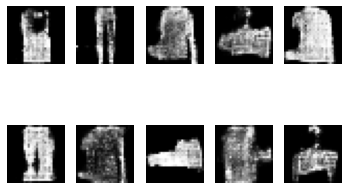

9801 [D loss: 0.694886, acc.: 44.14%] [G loss: 0.695546]
9802 [D loss: 0.693440, acc.: 48.83%] [G loss: 0.695068]
9803 [D loss: 0.694147, acc.: 48.44%] [G loss: 0.696254]
9804 [D loss: 0.692925, acc.: 49.61%] [G loss: 0.696183]
9805 [D loss: 0.692376, acc.: 54.69%] [G loss: 0.697085]
9806 [D loss: 0.693358, acc.: 47.66%] [G loss: 0.695394]
9807 [D loss: 0.693130, acc.: 48.83%] [G loss: 0.696530]
9808 [D loss: 0.693994, acc.: 47.66%] [G loss: 0.694417]
9809 [D loss: 0.693514, acc.: 47.66%] [G loss: 0.694037]
9810 [D loss: 0.694822, acc.: 40.23%] [G loss: 0.693169]
9811 [D loss: 0.694227, acc.: 45.70%] [G loss: 0.693620]
9812 [D loss: 0.693366, acc.: 50.00%] [G loss: 0.693379]
9813 [D loss: 0.694069, acc.: 44.14%] [G loss: 0.693266]
9814 [D loss: 0.694070, acc.: 46.48%] [G loss: 0.694550]
9815 [D loss: 0.694001, acc.: 46.09%] [G loss: 0.694388]
9816 [D loss: 0.692092, acc.: 55.86%] [G loss: 0.695671]
9817 [D loss: 0.692563, acc.: 53.91%] [G loss: 0.696921]
9818 [D loss: 0.692701, acc.: 5

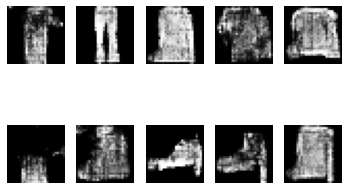

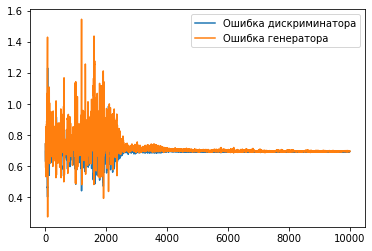

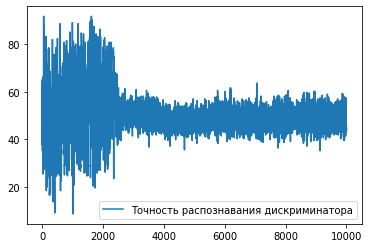

In [ ]:
train_conditional(conditional_generator, conditional_discriminator, 10000, sample_interval=200)

# Проверка

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
my_img = image.load_img('/content/drive/MyDrive/УИИ/Базы/Картинки из PAINT/8.png', color_mode = "grayscale")
my_img = image.img_to_array(my_img)
my_img = 255-my_img
my_img = my_img/127.5 - 1.0
my_img = my_img.reshape(28,28, 1)
noise = np.random.normal(0, 1, (1, latent_dim))

In [ ]:
my_img = np.array([np.array(my_img)])

In [ ]:
another_img = np.array([train_mnist[3]])
another_img.shape

(1, 28, 28, 1)

In [ ]:
my_gen_predict1 = conditional_generator.predict([noise, another_img])
my_gen_predict2 = conditional_generator.predict([noise, my_img])

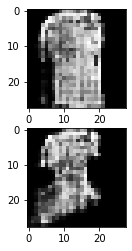

In [ ]:
plt.figure(figsize=((16, 4)))
plt.subplot(2, 1, 1)
plt.imshow(my_gen_predict1[0].reshape((28,28)), cmap='gray')
plt.subplot(2, 1, 2)
plt.imshow(my_gen_predict2[0].reshape((28,28)), cmap='gray')